# Lane lines detection


## **Overview** 
***
Through this project you'll be able to detect lane lines on the road in images and videos by creating Computer Vision process pipeline. 

## **Process pipeline**

 1. Convert the image to grayscale
 2. Blur the image using Gaussian filter
 3. Apply Canny edge detection
 4. Mask the edges detected
 5. Apply Hough transform

## Import Packages

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Some helper functions

In [19]:
# import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



def draw_lines(img, lines, color=[255, 0, 0], thickness=14):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
  
    left = np.empty((0,4), int)
    right = np.empty((0,4), int)

    # separate line segments by their slope
    for line in lines:
        for x1,y1,x2,y2 in line:
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness) 
            slope =  (y2-y1)/(x2-x1)
            if (slope < 0 and slope > -0.85 and (x1 < 500) and (x2 < 500)):  # right lane
                left = np.append(left, np.array([[x1, y1, x2, y2]]), axis=0)
            elif (slope > 0 and slope < 0.85 and (x1 > 500) and (x2 > 500)):  # left lane
                right = np.append(right, np.array([[x1, y1, x2, y2]]), axis=0)
               
    left_x1 = 0
    left_y1 = 0
    left_x2 = 0
    left_y2 = 0
    right_x1 = 0
    right_y1 = 0
    right_x2 = 0
    right_y2 = 0
    
    top_position_of_region = 330
    extrapolate_times = 10
        
    # calculate average the position of each of the lines, and extrapolate it. for left lane
    if len(left) != 0:    
        for point in left:
            left_x1 += point[0]
            left_y1 += point[1]
            left_x2 += point[2]
            left_y2 += point[3]

        # averaget position
        left_x1_avg = left_x1 / len(left)
        left_y1_avg = left_y1 / len(left)
        left_x2_avg = left_x2 / len(left)
        left_y2_avg = left_y2 / len(left)
        
        x_elm = left_x2_avg - left_x1_avg
        y_elm = left_y2_avg - left_y1_avg
        extrapolated_x1 = left_x1_avg - extrapolate_times * x_elm
        extrapolated_y1 =  left_y1_avg - extrapolate_times * y_elm
        
        grad = y_elm / x_elm
        x_diff = abs((left_y2_avg - top_position_of_region) / grad)
        cv2.line(img, (int(extrapolated_x1), int(extrapolated_y1)), (int(left_x2_avg + x_diff), int(top_position_of_region)), color, thickness) 

    # average and extrapolate for right lane
    if len(right) != 0:
        for point in right:
            right_x1 += point[0]
            right_y1 += point[1]
            right_x2 += point[2]
            right_y2 += point[3]

        right_x1_avg = right_x1 / len(right)
        right_y1_avg = right_y1 / len(right)
        right_x2_avg = right_x2 / len(right)
        right_y2_avg = right_y2 / len(right)
        
        x_elm = right_x2_avg - right_x1_avg
        y_elm = right_y2_avg - right_y1_avg
        extrapolated_x2 = right_x2_avg + extrapolate_times * x_elm
        extrapolated_y2 = right_y2_avg + extrapolate_times * y_elm
        
        grad = y_elm / x_elm
        x_diff = abs((right_y1_avg - top_position_of_region) / grad)
        cv2.line(img, (int(right_x1_avg - x_diff), int(top_position_of_region)), (int(extrapolated_x2), int(extrapolated_y2)), color, thickness) 

        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [20]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

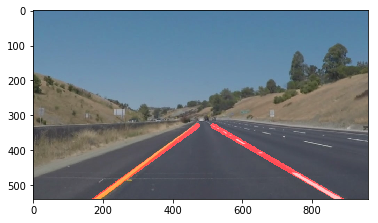

In [21]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

if not os.path.exists('test_images_output'):
    os.mkdir('test_images_output')

def find_lane_lines(file):
    
    # 1: convert to grayscale
    path = 'test_images/' + file
    image = mpimg.imread(path)
    gray = grayscale(image)

    # 2: blur
    gray_blurred = gaussian_blur(gray, 3)
    
    # 3: canny
    cannied = canny(gray_blurred, 100, 200)
    plt.imshow(cannied)
    
    # 4: mask
    imshape = cannied.shape
    vertices = np.array([[(80,imshape[0]),(450, 330), (520, 330), (imshape[1] - 50,imshape[0])]], dtype=np.int32)
    masked = region_of_interest(cannied, vertices)
    plt.imshow(masked)

    # 5: hough transforming
    rho = 2
    theta = np.pi/180 
    threshold = 15
    min_line_length = 40
    max_line_gap = 20
    lines = hough_lines(masked, rho, theta, threshold, min_line_length, max_line_gap)
    plt.imshow(lines)

    weighted = weighted_img(lines, image)
    plt.imshow(weighted)
    output_path = "test_images_output/" + file
    mpimg.imsave(output_path, weighted)
    
for file in os.listdir('test_images'):
    find_lane_lines(file)

 ## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [23]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    gray = grayscale(image)

    gray_blurred = gaussian_blur(gray, 3)
    cannied = canny(gray_blurred, 100, 200)
    plt.imshow(cannied)
    
    imshape = cannied.shape
    vertices = np.array([[(80,imshape[0]),(450, 330), (520, 330), (imshape[1] - 50,imshape[0])]], dtype=np.int32)
    masked = region_of_interest(cannied, vertices)
    plt.imshow(masked)

    rho = 2
    theta = np.pi/180 
    threshold = 15
    min_line_length = 40
    max_line_gap = 20

    lines = hough_lines(masked, rho, theta, threshold, min_line_length, max_line_gap)
    plt.imshow(lines)

    result = weighted_img(lines, image)

    return result

Let's try the one with the solid white lane on the right first ...

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


 99%|█████████▉| 125/126 [00:06<00:00, 20.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 4.92 s, sys: 456 ms, total: 5.38 s
Wall time: 7.78 s


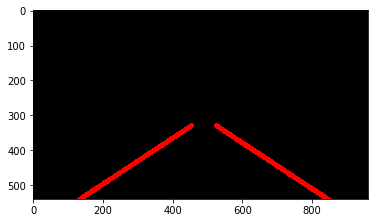

In [24]:
if not os.path.exists('test_videos_output'):
    os.mkdir('test_videos_output')

white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:37<00:00, 18.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 28 s, sys: 3.5 s, total: 31.5 s
Wall time: 38.1 s


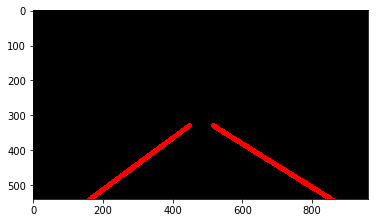

In [26]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:36<00:00,  6.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 20.7 s, sys: 3.27 s, total: 24 s
Wall time: 39.3 s


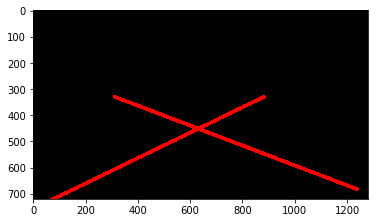

In [28]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))